## Detecting Minors 

#### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
import seaborn as sns
import cv2

import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score, confusion_matrix

#### Reading the dataset containing labels and age for the respective images

In [2]:
data = pd.read_csv('labels.csv')
data.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


C:\Users\mysta\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<Axes: xlabel='real_age', ylabel='Density'>

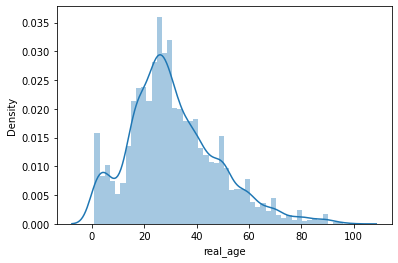

In [4]:
sns.distplot(data['real_age'], bins = 50)

#### Creating a bounding box around the face

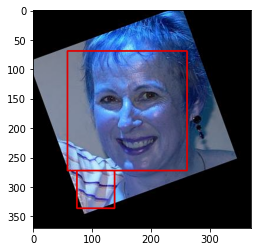

In [15]:
files = os.listdir('face_files')
path = (os.getcwd())+'\\face_files'+'\\'+files[3]
img = cv2.imread(path)

face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

faces = face_cascade.detectMultiScale(
gray_img,
scaleFactor=1.1,
minNeighbors=5,
flags=cv2.CASCADE_SCALE_IMAGE
)

for (x,y,w,h) in faces:
    cv2.rectangle(img,(x,y),(x+w,y+h),(225,0,0),2)
    
plt.imshow(img)

#### Preprocessing

In [7]:
# Creating age groups for different categories 
ranges = ['1-2','3-9','10-18','19-29','30-45','46-65','66-116']

# Creating a list containing all the labels of the images
flist = data['file_name'].tolist()
flist = flist[:3000]


X = []
X_arr = []
y = []

# Looping through images to resize and append it into a list
# and appending the categorical variable depending on the ages in another list
for image in flist:

    img_path =  'face_files/' + image
    color_img = cv2.imread(img_path)
    X.append(cv2.resize(color_img,(200,200)))
 
    age = data.loc[data['file_name'] == image, 'real_age'].iloc[0]
    
    if age>=1 and age<=2:
        y.append(0)
    elif age>=3 and age<=9:
        y.append(1)
    elif age>=10 and age<=18:
        y.append(2)
    elif age>=19 and age<=29:
        y.append(3)
    elif age>=30 and age<=45:
        y.append(4)
    elif age>=46 and age<=65:
        y.append(5)
    elif age>=66 and age<=116:
        y.append(6)

X = np.array(X)/255.0
y = np.array(y)             
#np.savez_compressed('compressed image data.npz',x=X,y=y)

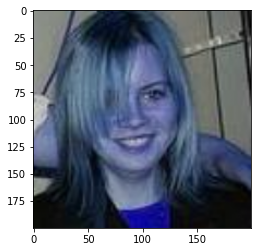

In [8]:
plt.imshow(X[19])

#### Creating the train, test split for model training

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)


In [10]:
#Run the cell only if memory is maxed out 
#del X, y

#### Model Building

In [11]:
y_train = tf.keras.utils.to_categorical(y_train, 7)

y_test = tf.keras.utils.to_categorical(y_test, 7)

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(7, activation = 'softmax') ])

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(
    X_train, 
    y_train, 
    batch_size = 32, 
    epochs=8, 
    validation_data=(X_test, y_test))

Epoch 1/8
66/66 [==============================] - 87s 1s/step - loss: 1.9147 - accuracy: 0.2714 - val_loss: 1.6977 - val_accuracy: 0.2811
Epoch 2/8
66/66 [==============================] - 79s 1s/step - loss: 1.6221 - accuracy: 0.3229 - val_loss: 1.6728 - val_accuracy: 0.2956
Epoch 3/8
66/66 [==============================] - 76s 1s/step - loss: 1.4875 - accuracy: 0.3952 - val_loss: 1.6814 - val_accuracy: 0.2822
Epoch 4/8
66/66 [==============================] - 76s 1s/step - loss: 1.2170 - accuracy: 0.5243 - val_loss: 1.8591 - val_accuracy: 0.2878
Epoch 5/8
66/66 [==============================] - 77s 1s/step - loss: 0.7744 - accuracy: 0.7186 - val_loss: 2.2071 - val_accuracy: 0.2622
Epoch 6/8
66/66 [==============================] - 77s 1s/step - loss: 0.3586 - accuracy: 0.8795 - val_loss: 3.5846 - val_accuracy: 0.2578
Epoch 7/8
66/66 [==============================] - 77s 1s/step - loss: 0.1276 - accuracy: 0.9614 - val_loss: 4.7715 - val_accuracy: 0.2656
Epoch 8/8
66/66 [==========

#### Converting the predicted values 

In [12]:
y_pred = model.predict(X_test)

threshold = 0.5  # set the threshold for classification

y_pred_binary = np.where(y_pred > threshold, 1, 0)
y_pred_binary

29/29 [==============================] - 6s 207ms/step


array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

#### Creating a list of ages 

In [13]:
def get_key(val):
    age_dict = {'1-2':0, '3-9':1, '10-18':2, '19-29':3, '30-45':4, '46-65':5, '66-116':6}
    for key, value in age_dict.items():
        if value == val:
            return key

result_ages = []

for result in y_pred_binary:
  
  if 1 in result:
    result_ages.append(get_key(list(result).index(1)))
  else:
    result_ages.append('cannot identify')

#### Displaying the image and predicted age

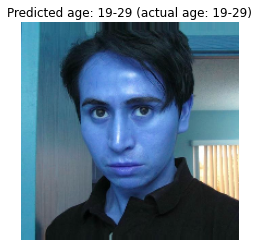

In [14]:
plt.imshow(X_test[6])
plt.title("Predicted age: {} (actual age: {})".format(result_ages[6], get_key(list(y_test[6]).index(1))))
plt.axis("off")
plt.show()
